## Import Libraries

In [1]:
import os
import fnmatch
import os.path
import re
import shutil
from pylab import *


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import skimage.io as io
from skimage.feature import canny, match_template, peak_local_max
from skimage.transform import resize
from skimage.draw import circle_perimeter, disk, ellipse

from scipy import ndimage, signal, spatial
import scipy.optimize as opt

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.cluster import KMeans, OPTICS
import sklearn.decomposition as skld
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams.update({'font.sans-serif':'Arial'})
from mpl_toolkits.axes_grid1 import make_axes_locatable

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Defining functions

In [2]:
def fullprint(*args, **kwargs):
    from pprint import pprint
    import numpy
    opt = numpy.get_printoptions()
    numpy.set_printoptions(threshold=numpy.inf)
    pprint(*args, **kwargs)
    numpy.set_printoptions(**opt)

In [3]:
def GaussSingle(xydata, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xydata
    xo = float(xo)
    yo = float(yo)    
    a = 1/(2*sigma_x**2)
    c = 1/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g.ravel()

def lowest(a, n): return np.partition(a, n-1)[:n]
def highest(a, n): return np.partition(a, len(a)-n-1)[-n:]

def get_avg_dp(labels_arr, label_num, nbed_array):
    labelloc = np.array(np.where(labels_arr == label_num)).T
    nbed_base = np.zeros((nbed_array[0].shape[0],nbed_array[0].shape[1]))
    for i in range(len(labelloc)):
        nbed_base += nbed_array[labelloc[i]][0]
    
    return nbed_base/len(labelloc)

## Import data

We are going to import dataset(s) through raw_list, which takes the name of the .raw 4DSTEM dataset. Then, load_raw_file will take each of those datasets and add them to nbeds and ceps. This load file function keeps the center beam, but you could adjust it to remove the center beam from the nbeds. The start and end list are the y-axis values you would like to use from the 4DSTEM set, if you want to vertically crop the data set you can adjust that here.

In [5]:
ceps = {}
nbeds = {}

In [6]:
#E:\Group Data Storage\Timothy Yoo\Experimental\SMA GaFIB THIN\Scan1 163.8x63.7 410x160

raw_list = ["SinglePrecipitate_scan_x160_y410.raw"] #raw 4D STEM dataset
start_list = [0] #rough estimation of where the film area is
end_list = [410]

In [7]:
hann = signal.windows.hann(128, sym = True)
def load_raw_file(file_loc, num_entries, count, padding, reshapey, reshapex, min1, max1):
    dest_arr_cep = []
    dest_arr = []
    with open(file_loc, 'rb') as f:
        for i in range(num_entries):
            im = np.fromfile(f, dtype = 'float32', count = count)
            im = im.reshape(128,128)
            im = im - im.min()
            im = im/im.max()
            dest_arr.append(im.ravel())
            
            ln = np.log(im + 0.00001)
            Cep = np.abs(np.fft.fftshift(np.fft.fft2(hann*ln)))
            Cep = Cep - Cep.min()
            Cep = Cep/Cep.max()
            dest_arr_cep.append(Cep.ravel())
            f.read(padding) # skip value in bytes
    dest_arr_cep = (np.asarray(dest_arr_cep).reshape(reshapey, reshapex, count))[min1:max1]
    dest_arr = (np.asarray(dest_arr).reshape(reshapey, reshapex, count))[min1:max1]
    num_data = dest_arr.shape[0]*dest_arr.shape[1]
    return dest_arr_cep.reshape(num_data, count), dest_arr.reshape(num_data, count)

In [8]:
%%time
for i in range(len(raw_list)):
    ceps[i], nbeds[i] = load_raw_file('E:\Group Data Storage\Timothy Yoo\Experimental\SMA GaFIB THIN\Scan1 163.8x63.7 410x160\\' + raw_list[i], 65600, 128**2, 1024, 410, 160, start_list[i], end_list[i])
    print(ceps[i].shape, nbeds[i].shape)

(65600, 16384) (65600, 16384)
CPU times: total: 2min 14s
Wall time: 2min 14s


In [9]:
ScanX = 410
ScanY = 160

In [10]:
IMG_SIZE = 128
SET_SIZE = int(ScanX*ScanY)

## PCA

PCA (Principle Component Analysis) is a simple dimensionality reduction methods. See the powerpoint in the USML training folder for more details.

In [33]:
#Everything is written in terms of the the length of the raw list, this just represents the number of raw datasets you have
#If you had multiple you could upload them simulataneously using raw_list and adjusting the load_raw_file file location parameter

%%time
sma_pca_list = [None] * len(raw_list)
sma_pca_cep_list = [None] * len(raw_list)

for i in range(len(raw_list)):
    #Standard NBED PCA
    pca = skld.PCA(n_components = 5, random_state = 0)
    sma_pca_list[i] = pca.fit_transform(nbeds[i])
    #Cepstral Transformed NBED PCA
    pca_cep = skld.PCA(n_components = 5, random_state = 0)
    sma_pca_cep_list[i] = pca_cep.fit_transform(ceps[i])

CPU times: total: 1min 18s
Wall time: 17.5 s


In [34]:
pca1c = pca.components_
pca1_cepc = pca_cep.components_

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

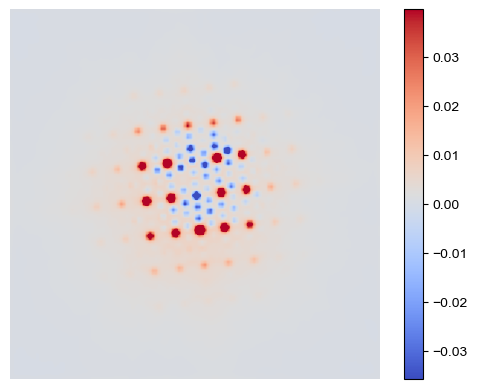

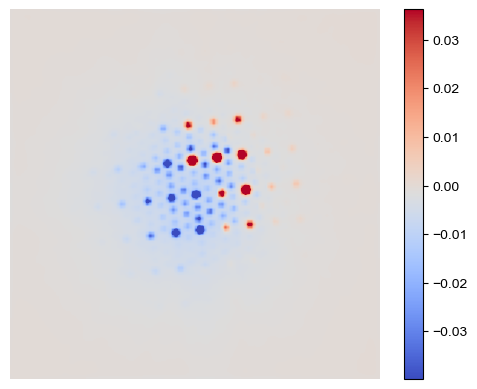

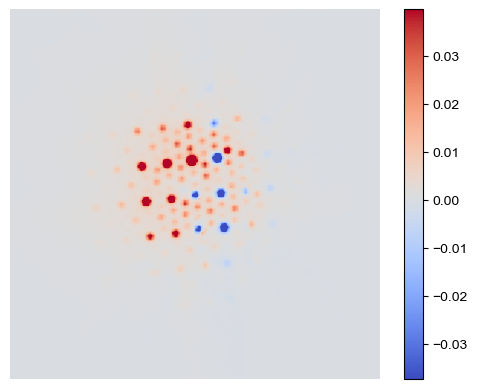

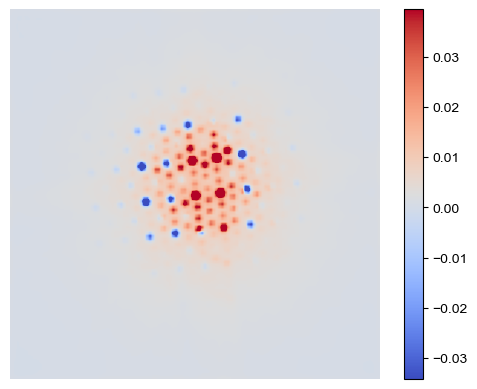

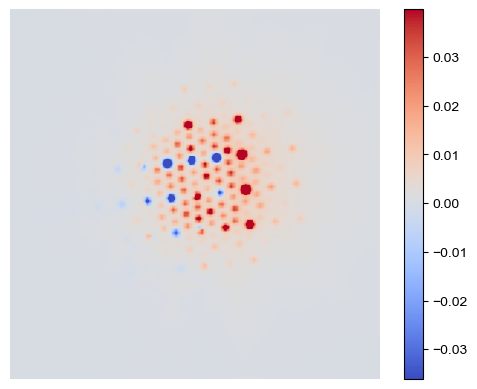

In [35]:
#Components of NBED PCA
for i in range(5):
    plt.figure()
    plt.imshow(pca1c[i].reshape(IMG_SIZE, IMG_SIZE), cmap = 'coolwarm')
    plt.axis('off')
    plt.colorbar()
    plt.clim([pca1c[i].mean() - 5*pca1c[i].std(), pca1c[i].mean() + 5*pca1c[i].std()])

In [38]:
#Determining optimal number of kmeans clusters for NBED PCA
kp_inertia = []
for dataset_number in range(len(raw_list)):
    for num_cluster in range(2, 10):
        temp_inertia = []
        for j in range(0,10):
            kmeans_pca_run = KMeans(n_clusters = num_cluster, n_init = 10).fit(sma_pca_list[dataset_number])
            temp_inertia.append(kmeans_pca_run.inertia_)
        kp_inertia.append(np.asarray(temp_inertia).mean())
kp_inertia = np.asarray(kp_inertia)  

In [39]:
np.round(kp_inertia/10000,2)

array([6.8 , 5.17, 4.28, 3.75, 3.27, 2.91, 2.7 , 2.5 ], dtype=float32)

Here we can plot the number of clusters vs the inertia to find the elbow point. This helps determine what the ideal number of clusters is.

Text(0.5, 1.0, 'NBED: Inertia vs # Clusters')

Text(0, 0.5, 'Inertia')

Text(0.5, 0, 'Number of Clusters')

([<matplotlib.axis.XTick at 0x207d2ed0be0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

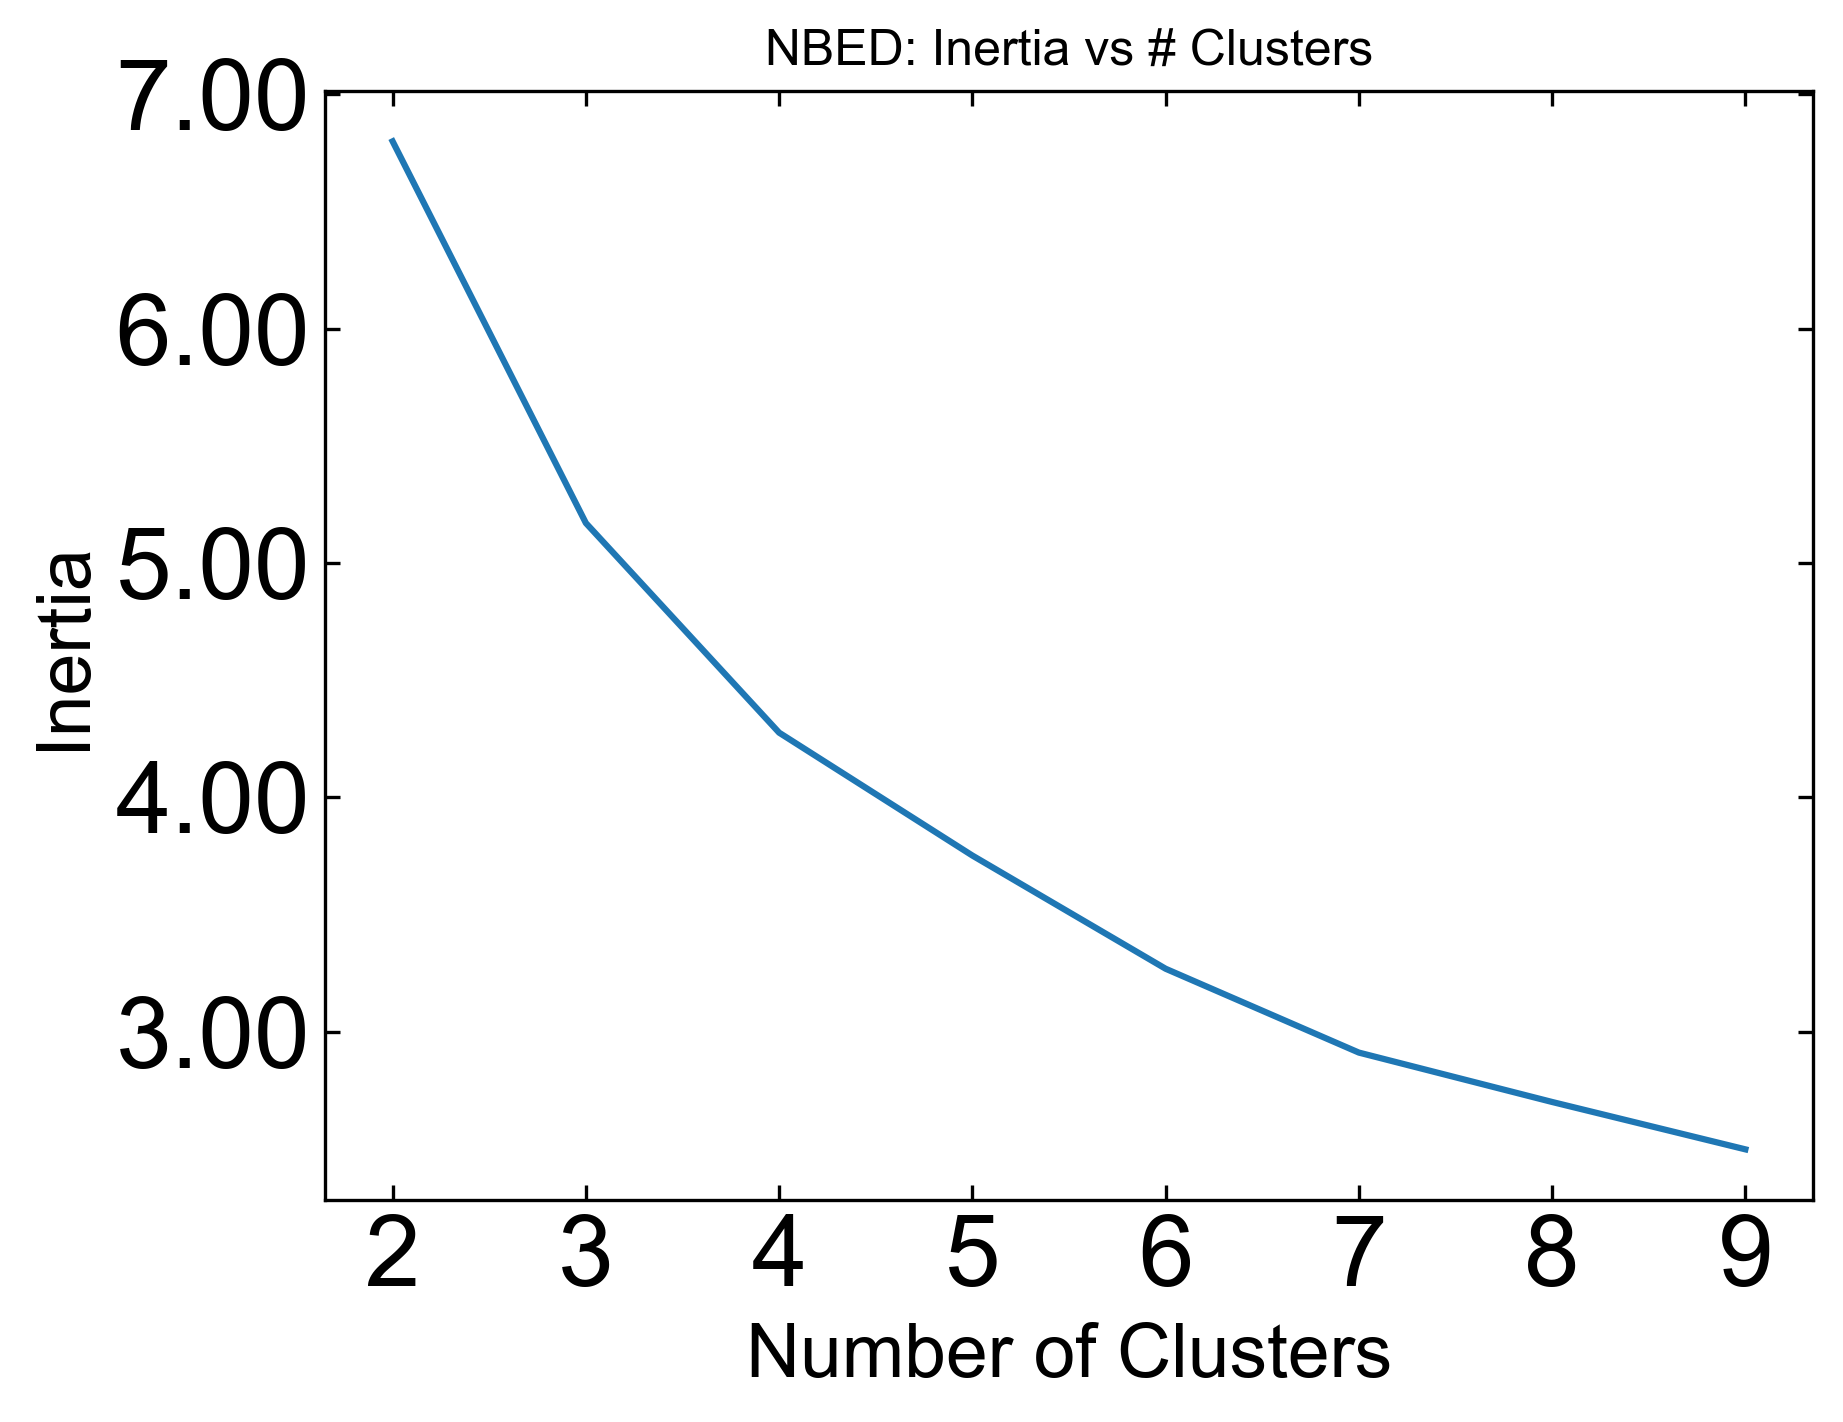

In [160]:
fig, ax = plt.subplots(dpi = 300)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,10,1)
ax.plot(n[0:9], kp_inertia[0:9]/10000)
plt.title("NBED: Inertia vs # Clusters")
plt.ylabel('Inertia', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 18)
plt.xticks(n[0:9],n[0:9])

In [43]:
#Determining optimal number of kmeans clusters for Cepstral PCA
kcp_inertia = []
for dataset_number in range(len(raw_list)):
    for i in range(2, 10):
        temp_inertia = []
        for j in range(0,10):
            kmeans_cep_pca_run = KMeans(n_clusters = i, n_init = 10).fit(sma_pca_cep_list[dataset_number])
            temp_inertia.append(kmeans_cep_pca_run.inertia_)
        kcp_inertia.append(np.asarray(temp_inertia).mean())
    kcp_inertia = np.asarray(kcp_inertia)

Text(0.5, 1.0, 'Cepstrum: Inertia vs # Clusters')

([<matplotlib.axis.XTick at 0x2079bbe1970>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

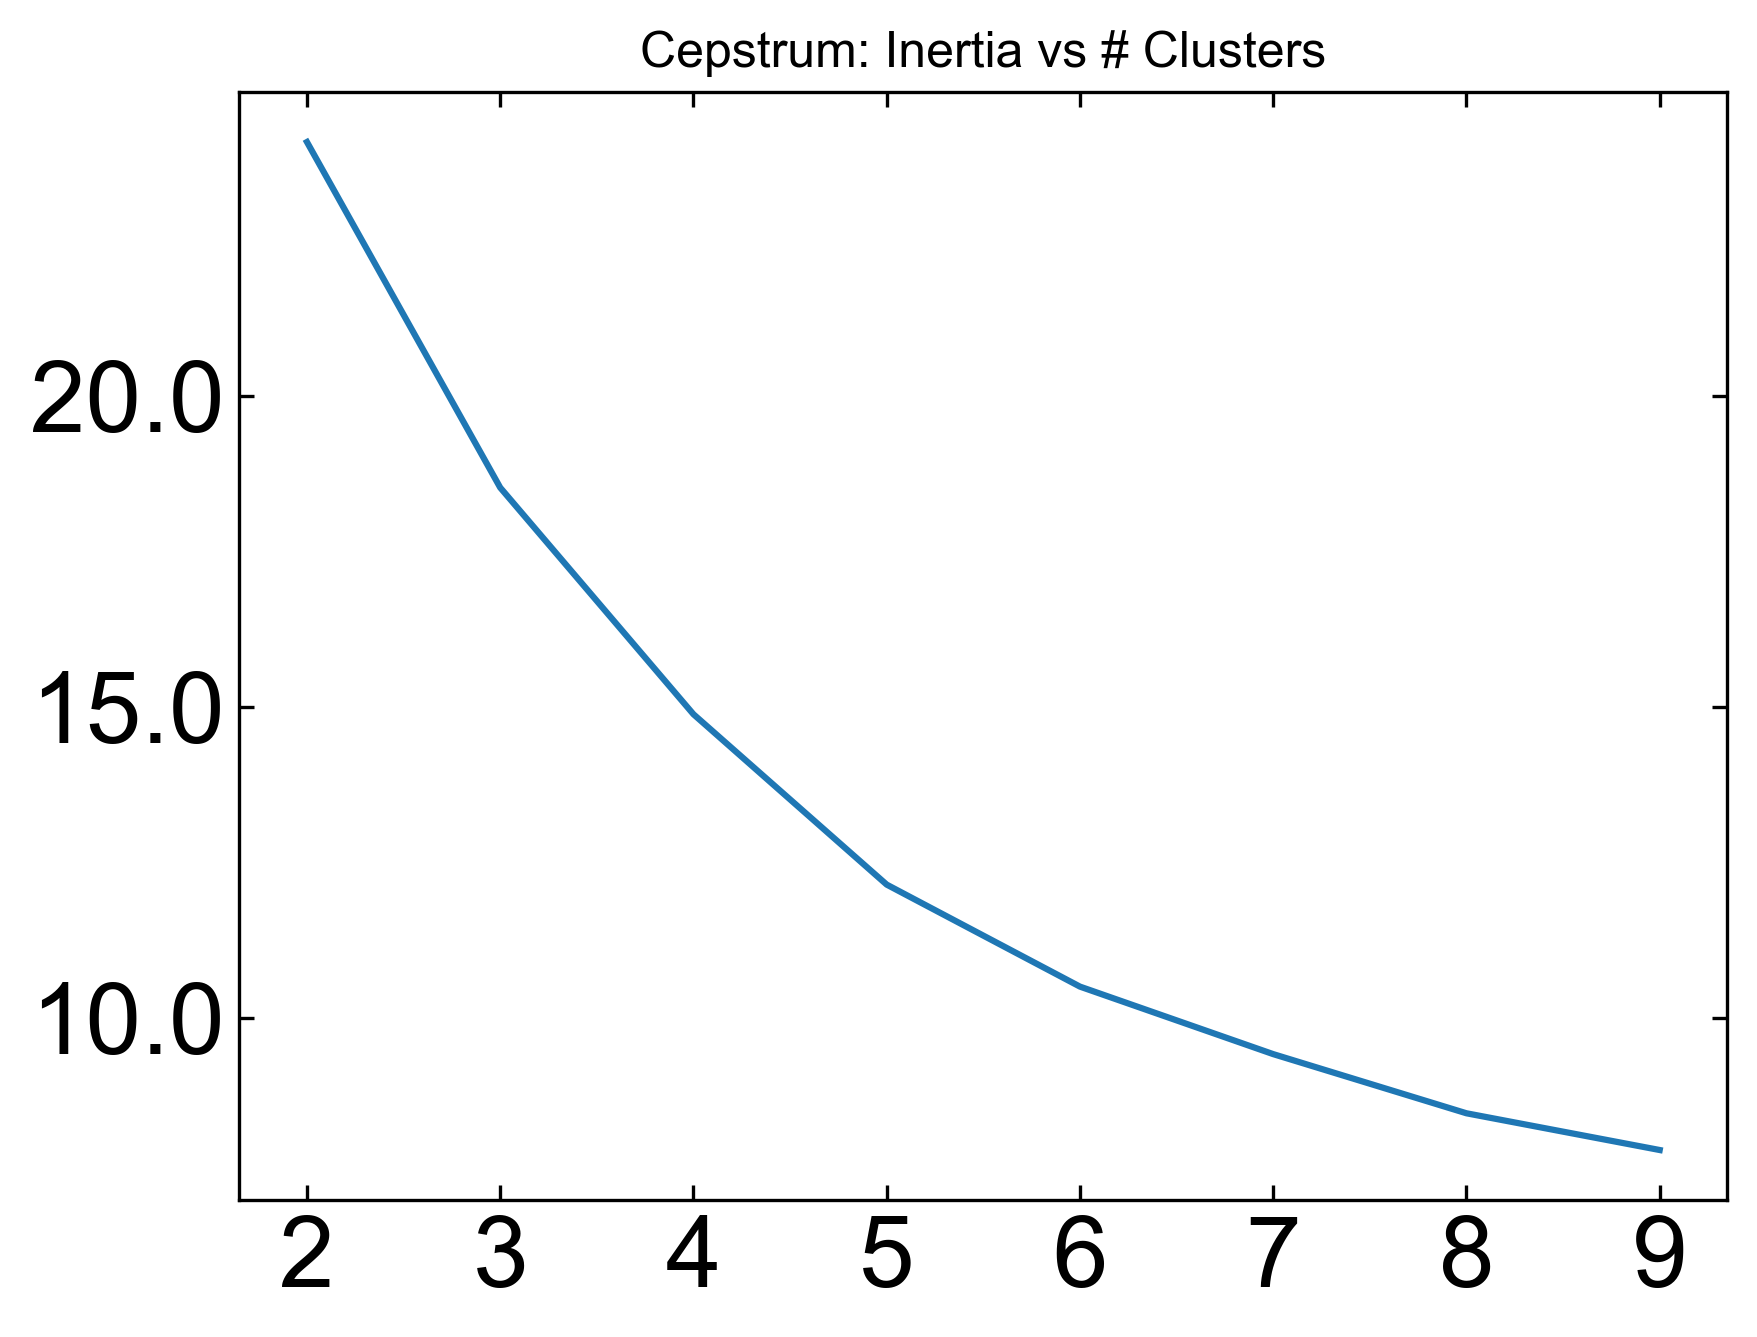

In [44]:
fig, ax = plt.subplots(dpi = 300)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,10,1)
ax.plot(n[0:9], kcp_inertia[0:9])
plt.title("Cepstrum: Inertia vs # Clusters")
plt.xticks(n[0:9],n[0:9])

We see that there are dips are 3, 4, and 5. Now we can plot the cluster maps which should have some resemblance to the vADF image from the 4DSTEM dataset.

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_23172\1669371944.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_pca, cmap = cm.get_cmap('RdYlBu', nckp))


(-0.5, 159.5, 409.5, -0.5)

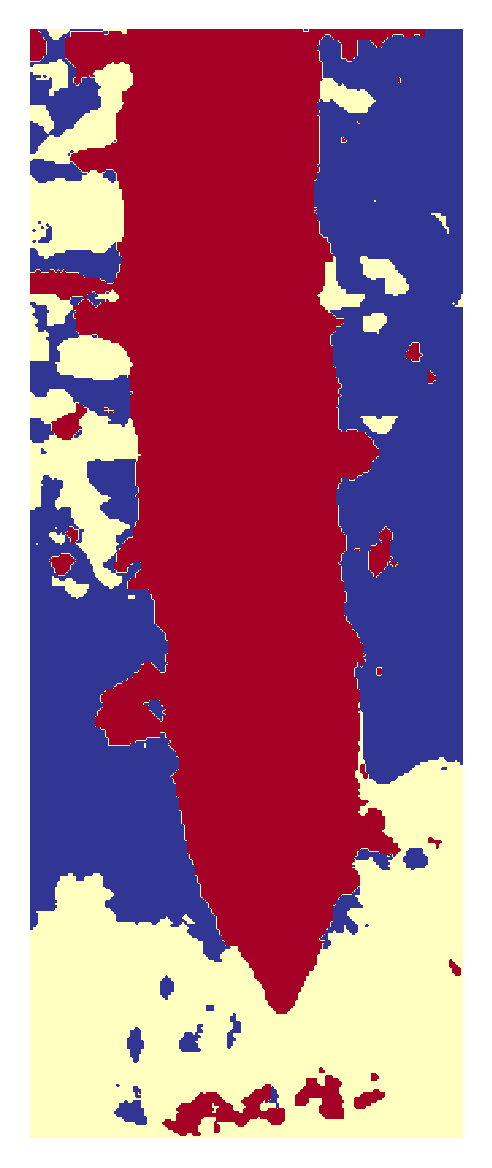

In [49]:
#Could make a case for 3, 4, or 5
nckp = 3
for dataset_number in range(len(raw_list)):
    kmeans_pca = KMeans(n_clusters = nckp, n_init = 10).fit(sma_pca_list[dataset_number]) # k = # of clusters

plt.figure(dpi = 300)
cluster_map_pca = (np.reshape(kmeans_pca.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_pca, cmap = cm.get_cmap('RdYlBu', nckp))
#plt.colorbar(ticks = np.arange(nckp)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [50]:
pca_avg_dict = {}
for i in range(len(raw_list)):
    for x in range(nckp):
        pca_avg_dict["nbed_{0}_avg_pca".format(x)] = get_avg_dp(kmeans_pca.labels_, x, nbeds[i].reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 NBED')

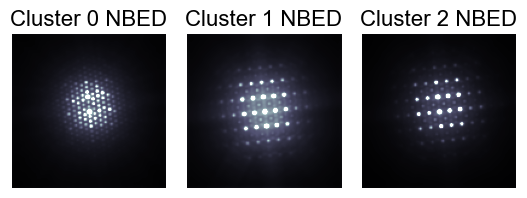

In [51]:
#Average NBED pattern of each cluster
clim_ref2 = pca_avg_dict["nbed_2_avg_pca"]
n_max = clim_ref2.mean() + 3*clim_ref2.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (6, 2))
im1 = ax1.imshow(pca_avg_dict["nbed_0_avg_pca"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 NBED', fontsize = 16)
im2 = ax2.imshow(pca_avg_dict["nbed_1_avg_pca"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 NBED', fontsize = 16)
im3 = ax3.imshow(pca_avg_dict["nbed_2_avg_pca"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 NBED', fontsize = 16)

fig.subplots_adjust(right=1)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_23172\4215226101.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_cep_pca, cmap = cm.get_cmap('RdYlBu',nckpc))


(-0.5, 159.5, 409.5, -0.5)

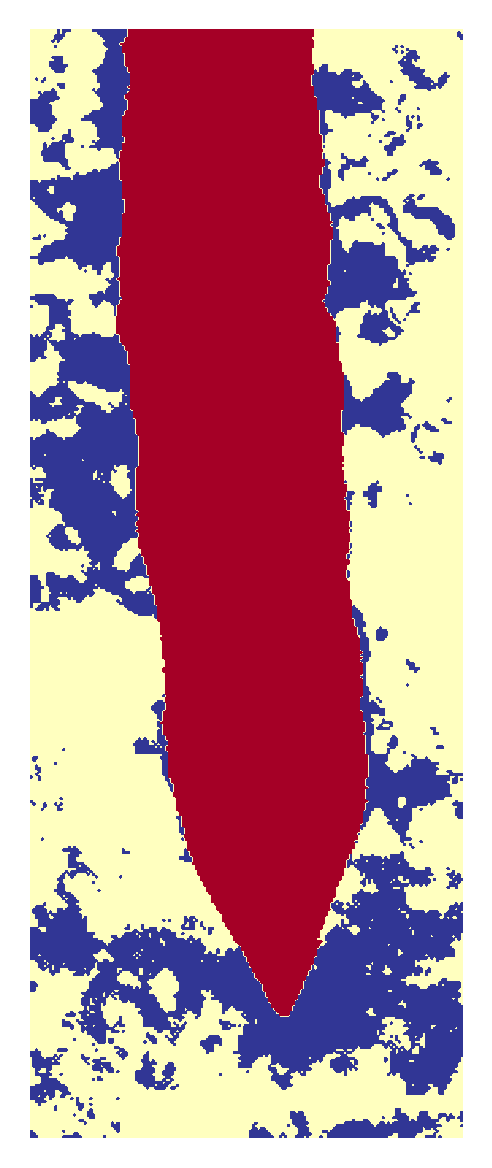

In [52]:
nckpc = 3
for dataset_number in range(len(raw_list)):
    kmeans_cep_pca = KMeans(n_clusters = nckpc, n_init = 10).fit(sma_pca_cep_list[dataset_number]) # k = # of clusters

plt.figure(dpi = 300)
plt.tight_layout(pad=0)
cluster_map_cep_pca = (np.reshape(kmeans_cep_pca.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_cep_pca, cmap = cm.get_cmap('RdYlBu',nckpc))
#plt.colorbar(ticks = np.arange(nckpc)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [56]:
pca_cep_avg_dict = {}
for i in range(len(raw_list)):
    for x in range(nckpc):
        pca_cep_avg_dict["cep_{0}_avg_pca_cep".format(x)] = get_avg_dp(kmeans_cep_pca.labels_, x, ceps[i].reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 Cep')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 Cep')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 Cep')

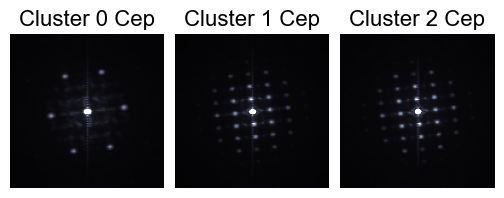

In [58]:
#Average Cepstral pattern of each cluster
clim_ref = pca_cep_avg_dict["cep_1_avg_pca_cep"]
n_max = clim_ref.mean() + 1*clim_ref.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (6, 2))
im1 = ax1.imshow(pca_cep_avg_dict["cep_0_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 Cep', fontsize = 16)
im2 = ax2.imshow(pca_cep_avg_dict["cep_1_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 Cep', fontsize = 16)
im3 = ax3.imshow(pca_cep_avg_dict["cep_2_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 Cep', fontsize = 16)

fig.subplots_adjust(right=0.95)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

## NMF

NMF (Non-negative matrix factorization) is another dimensionality reduction method that relies on non-negative components. For more details see the USML training powerpoint.

In [246]:
%%time
sma_nmf = [None] * len(raw_list)
sma_nmf_cep = [None] * len(raw_list)

for i in range(len(raw_list)):
    nmf = skld.NMF(n_components = 30, solver = 'mu', max_iter = 10000, init = None, random_state = 0)
    sma_nmf[i] = nmf.fit_transform(nbeds[i])
    print(nmf.n_iter_)
    
    cnmf = skld.NMF(n_components = 30, solver = 'mu', max_iter = 10000, init = None, random_state = 0)
    sma_nmf_cep[i] = cnmf.fit_transform(ceps[i])
    print(cnmf.n_iter_)

510
540
CPU times: total: 1h 24min 18s
Wall time: 17min 56s


In [180]:
np.save('smaGanmfWhole-160x410', sma_nmf)
np.save('smaGanmfcepWhole-160x410', sma_nmf_cep)

In [227]:
sma_nmf = np.load('smaGanmfWhole-160x410.npy')
sma_nmf_cep = np.load('smaGanmfcepWhole-160x410.npy')

In [182]:
sma_nmf.shape
H0 = nmf.components_
H0.shape

(1, 65600, 30)

(30, 16384)

(-0.5, 127.5, 127.5, -0.5)

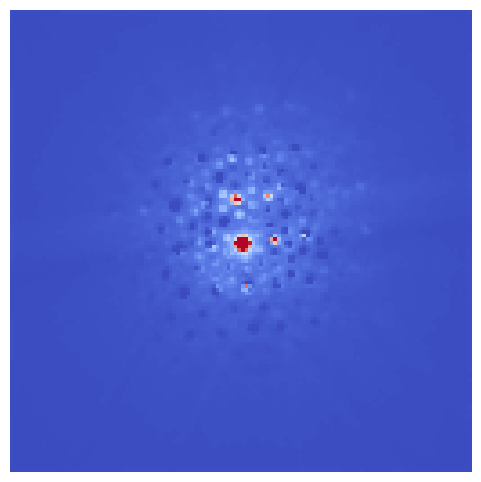

(-0.5, 127.5, 127.5, -0.5)

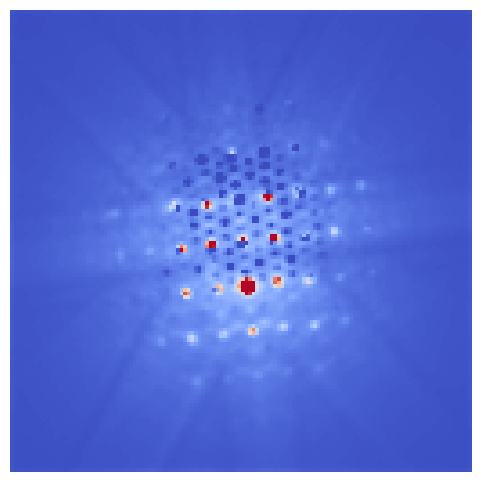

(-0.5, 127.5, 127.5, -0.5)

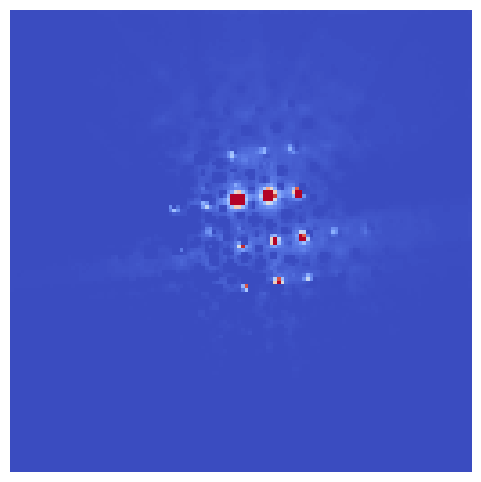

(-0.5, 127.5, 127.5, -0.5)

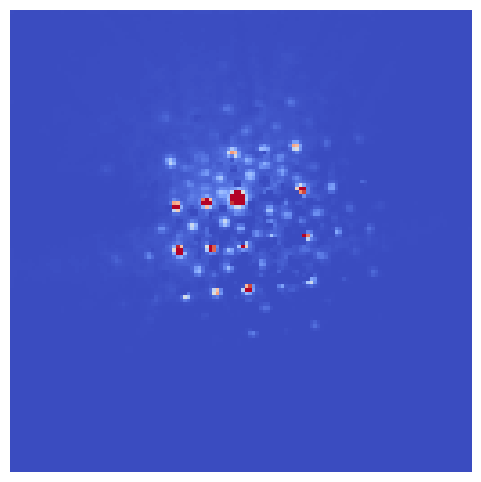

(-0.5, 127.5, 127.5, -0.5)

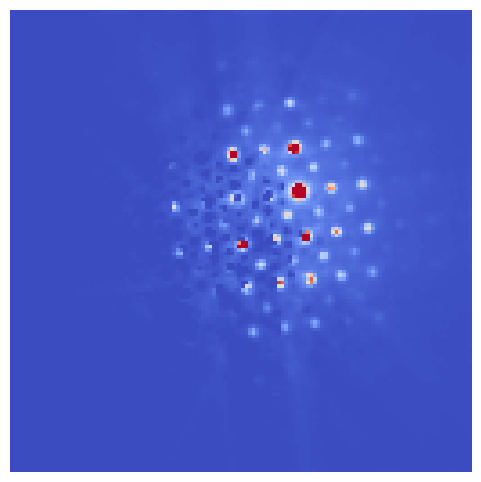

In [183]:
for i in range(5):
    fig, (ax1) = plt.subplots(1,1, figsize = (6,6))
    im1 = ax1.imshow(H0[i].reshape(IMG_SIZE, IMG_SIZE), cmap = 'coolwarm')
    ax1.axis('off')
    #ax1.set_title('nmf1 - 10 comp', fontsize = 26)
    im1.set_clim(0, 3*H0[i].std())


    plt.show()

(-0.5, 159.5, 409.5, -0.5)

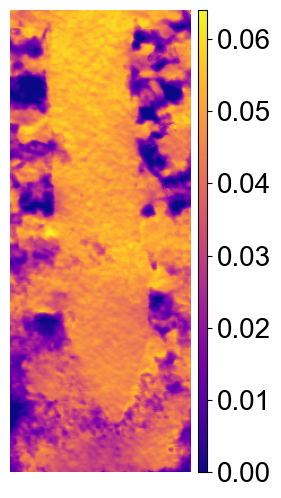

(-0.5, 159.5, 409.5, -0.5)

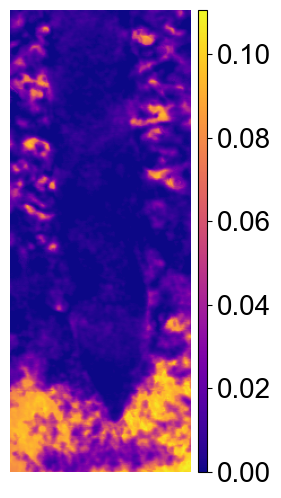

(-0.5, 159.5, 409.5, -0.5)

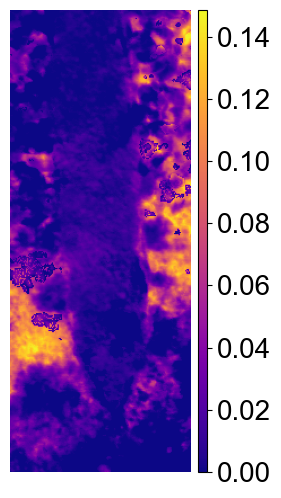

(-0.5, 159.5, 409.5, -0.5)

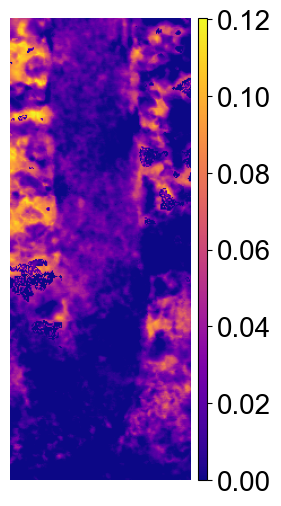

(-0.5, 159.5, 409.5, -0.5)

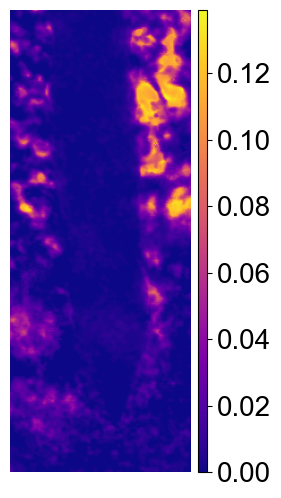

In [184]:
for i in range(5):
    fig, (ax1) = plt.subplots(1,1, figsize = (12,6))
    im1 = ax1.imshow(sma_nmf[:,:,i].reshape(ScanX, ScanY).reshape(ScanX, ScanY), cmap = 'plasma')
    ax1.axis('off')
    #ax1.set_title('Old - Comp ' + str(i + 1), fontsize = 20)
    #im1.set_clim(0, 2*H1[i].std())
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.08)
    fig.colorbar(im1, cax=cax, orientation='vertical').ax.tick_params(labelsize = 20)



#     fig.subplots_adjust(right=.9)
#     cbar_ax = fig.add_axes([0.9, 0.1, 0.015, 0.8]) # upper and lower limits, width, and length
#     fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 20)
#     plt.subplots_adjust(wspace=0)
#     plt.show()

    plt.show()

## Determing number of clusters for K means clustering for NMF

In [77]:
%%time

#using the first data set to run this (nbeds[0])
#If you wanted to do multiple datasets, you could set up a for loop to iterate over the raw_list like before


rmse_nmf = []
best_n_nmf = 0
actual_rmse_nmf = 1000000

for i in range(2,16):
    temp_rmse = []
    for j in range(0,10):
        nmf_run = skld.NMF(n_components = i, solver = 'mu', max_iter = 5000)
        nmf_run_fit = nmf_run.fit_transform(nbeds[0])
        nmf_rec_flat = (nmf_run.inverse_transform(nmf_run_fit))
        curr_rmse = mean_squared_error(nbeds[0], nmf_rec_flat, squared = False)
        temp_rmse.append(curr_rmse)
    avg_rmse = np.asarray(temp_rmse).mean()
    rmse_nmf.append(np.asarray(avg_rmse).mean())
    if avg_rmse < actual_rmse_nmf:
        actual_rmse_nmf = avg_rmse
        best_n_nmf = i
    else:
        actual_rmse_nmf = actual_rmse_nmf
        best_n_nmf = best_n_nmf

CPU times: total: 1d 17h 56min 38s
Wall time: 9h 20min 14s


In [78]:
np.save('rmse_nmf_SMAWholePrec', np.array(rmse_nmf))

<Figure size 1920x1440 with 0 Axes>

Text(0.5, 1.0, 'RMSE for NBED Data')

Text(0, 0.5, 'RMSE')

Text(0.5, 0, 'Number of Components')

([<matplotlib.axis.XTick at 0x207b2a4d7f0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

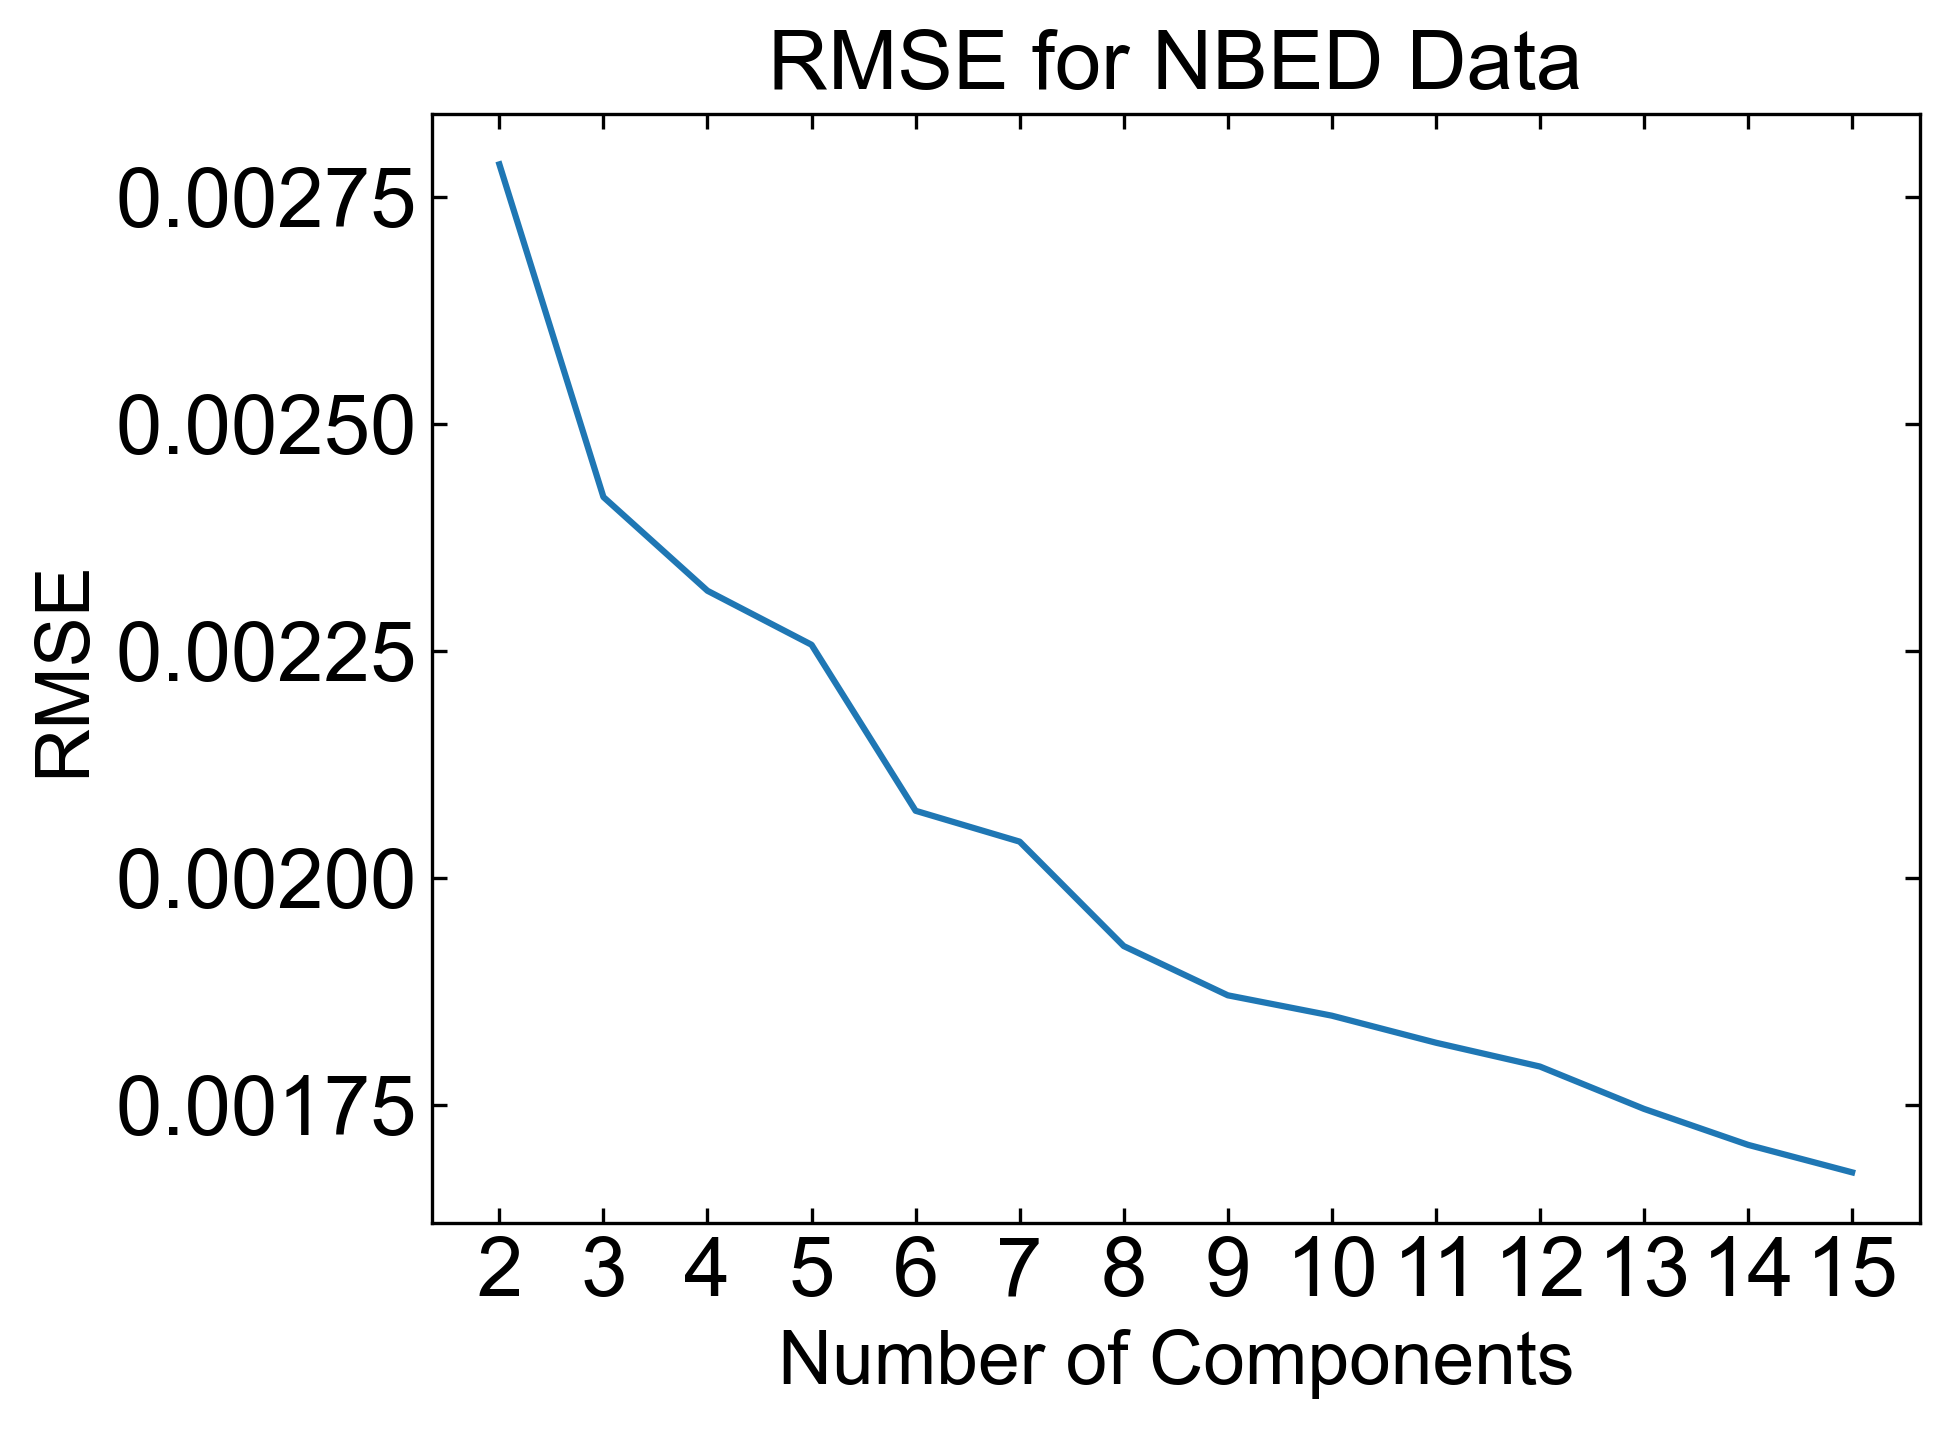

In [79]:
plt.figure(dpi = 300)
x = np.arange(2,16,1)
plt.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
plt.plot(x, rmse_nmf)
plt.title('RMSE for NBED Data', fontsize = 20)
plt.ylabel('RMSE', fontsize = 18)
plt.xlabel('Number of Components', fontsize = 18)
plt.xticks(x, x)

In [85]:
kn_inertia = []
sma_nmf_1 = sma_nmf[0,:,:]
for i in range(2, 12):
    temp_inertia = []
    for j in range(0,10):
        kmeans_nmf_run = KMeans(n_clusters = i, n_init = 10).fit(sma_nmf_1[:,:5]) #k means only accepts arrays of 2 dimensions, so we have to split up the datasets
        temp_inertia.append(kmeans_nmf_run.inertia_)
    kn_inertia.append(np.asarray(temp_inertia).mean())
kn_inertia = np.asarray(kn_inertia)

<Figure size 1920x1440 with 0 Axes>

Text(0.5, 1.0, 'NBED: Inertia vs # Clusters')

Text(0, 0.5, 'Inertia')

Text(0.5, 0, 'Number of Clusters')

([<matplotlib.axis.XTick at 0x207d2eb2c70>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

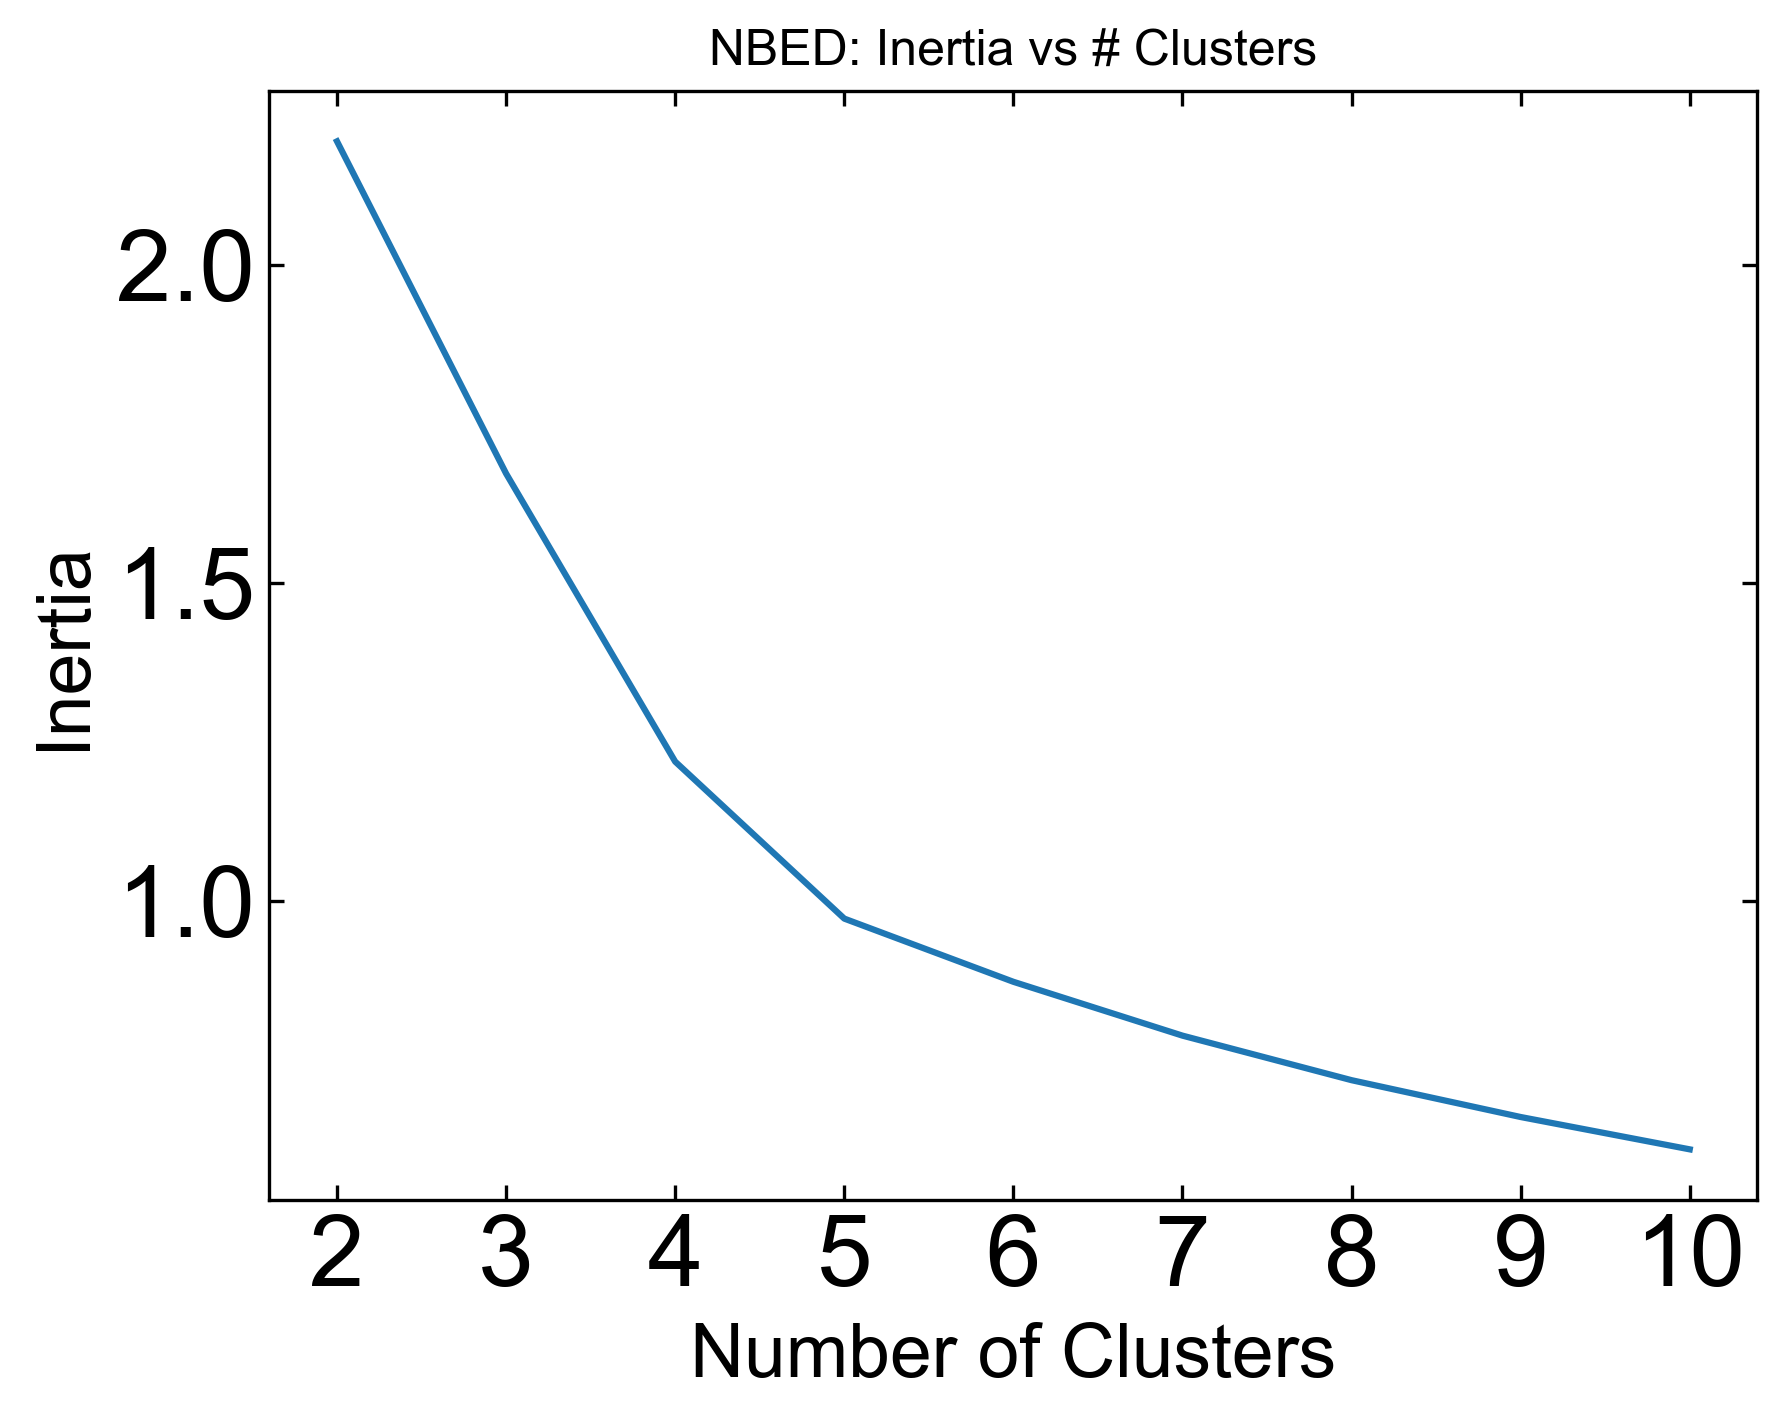

In [161]:
plt.figure(dpi = 300)
plt.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,12,1)
plt.plot(n[0:9], kn_inertia[0:9]/100)
plt.title("NBED: Inertia vs # Clusters")
plt.ylabel('Inertia', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 18)
plt.xticks(n[0:9],n[0:9])

In [87]:
%%time
rmse_nmf_cep = []
best_n_nmfcep = 0
actual_rmse_nmfcep = 1000000

for i in range(2,16):
    temp_rmse = []
    for j in range(0,10):
        nmf_run = skld.NMF(n_components = i, solver = 'mu', max_iter = 5000)
        nmf_run_fit = nmf_run.fit_transform(ceps[0])
        cep_nmf_rec_flat = (nmf_run.inverse_transform(nmf_run_fit))
        curr_rmse = mean_squared_error(ceps[0], cep_nmf_rec_flat, squared = False)
        temp_rmse.append(curr_rmse)
    avg_rmse = np.asarray(temp_rmse).mean()
    rmse_nmf_cep.append(np.asarray(avg_rmse).mean())
    if avg_rmse < actual_rmse_nmfcep:
        actual_rmse_nmfcep = avg_rmse
        best_n_nmfcep = i
    else:
        actual_rmse_nmfcep = actual_rmse_nmfcep
        best_n_nmfcep = best_n_nmfcep

CPU times: total: 4d 15h 5min 48s
Wall time: 1d 1h 46min


In [89]:
np.save('rmse_nmfcep_SMAWholePrec', np.array(rmse_nmf_cep))
rmse_nmf_cep = np.load('rmse_nmfcep_SMAWholePrec.npy')

Text(0.5, 1.0, 'RMSE for Cepstrum Data')

Text(0, 0.5, 'RMSE')

Text(0.5, 0, 'Number of Components')

([<matplotlib.axis.XTick at 0x207c0806610>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

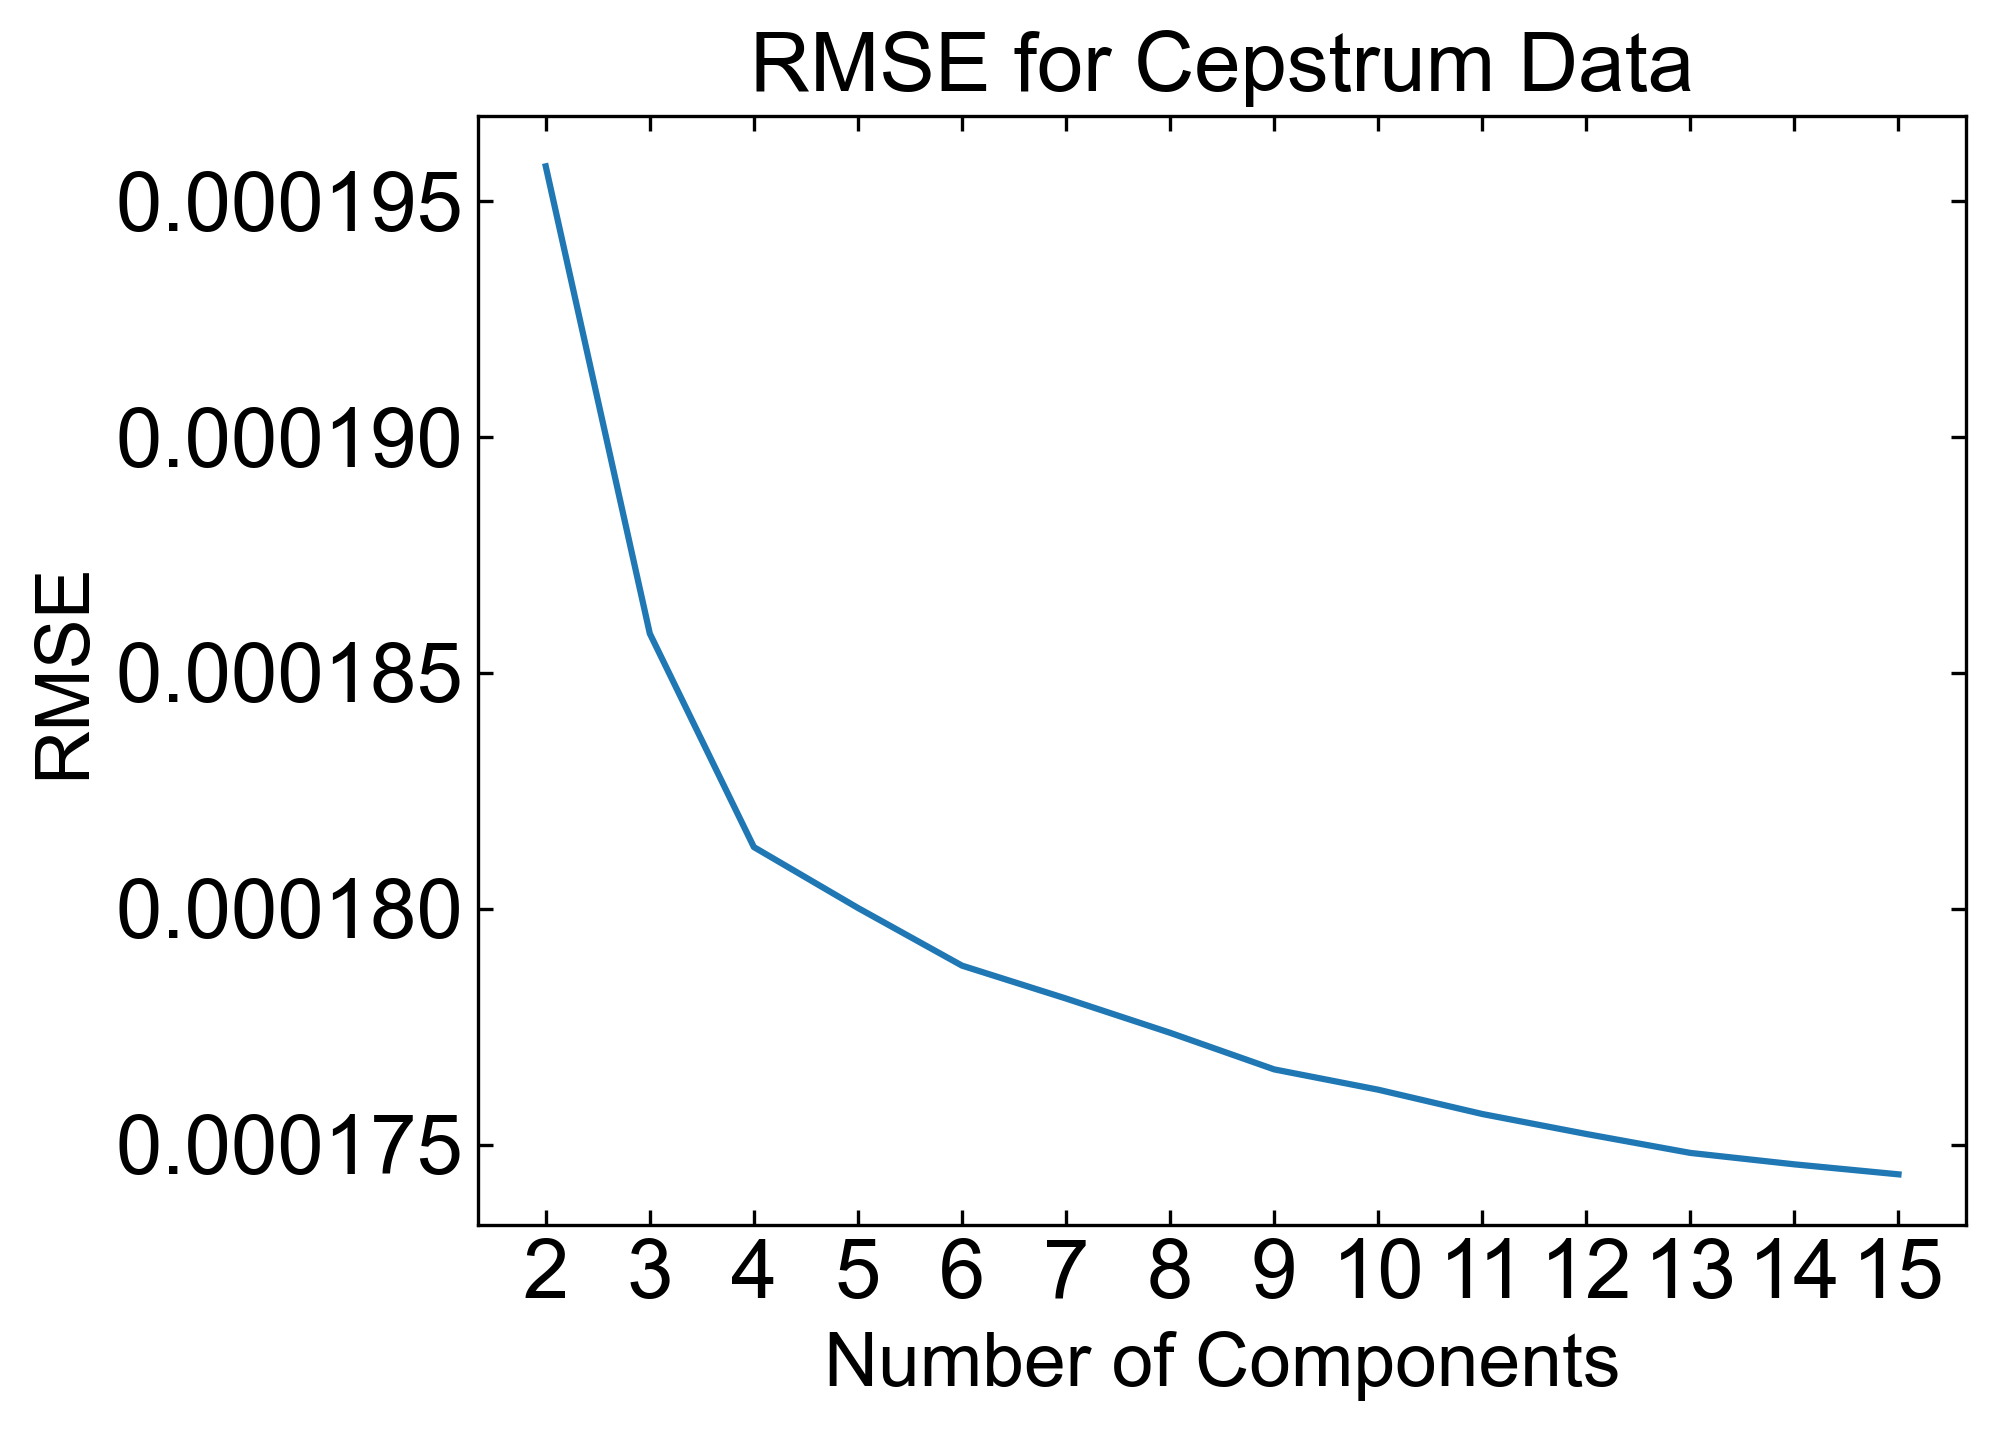

In [90]:
x = np.arange(2,16,1)
fig, ax = plt.subplots(1, 1, dpi = 300)
ax.plot(x, rmse_nmf_cep)
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
plt.title('RMSE for Cepstrum Data', fontsize = 20)
plt.ylabel('RMSE', fontsize = 18)
plt.xlabel('Number of Components', fontsize = 18)
plt.xticks(x,x)

In [91]:
kcn_inertia = []
sma_nmf_cep_1 = sma_nmf_cep[0,:,:] #k means only accepts arrays of 2 dimensions, so we have to split up the datasets
for i in range(2, 12):
    temp_inertia = []
    for j in range(0,10):
        kmeans_cep_nmf_run = KMeans(n_clusters = i, n_init = 10).fit(sma_nmf_cep_1[:,:5])
        temp_inertia.append(kmeans_cep_nmf_run.inertia_)
    kcn_inertia.append(np.asarray(temp_inertia).mean())
kcn_inertia = np.asarray(kcn_inertia)

Text(0.5, 1.0, 'Cepstrum: Inertia vs # Clusters')

Text(0, 0.5, 'Inertia')

Text(0.5, 0, 'Number of Clusters')

([<matplotlib.axis.XTick at 0x207d2fc4cd0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

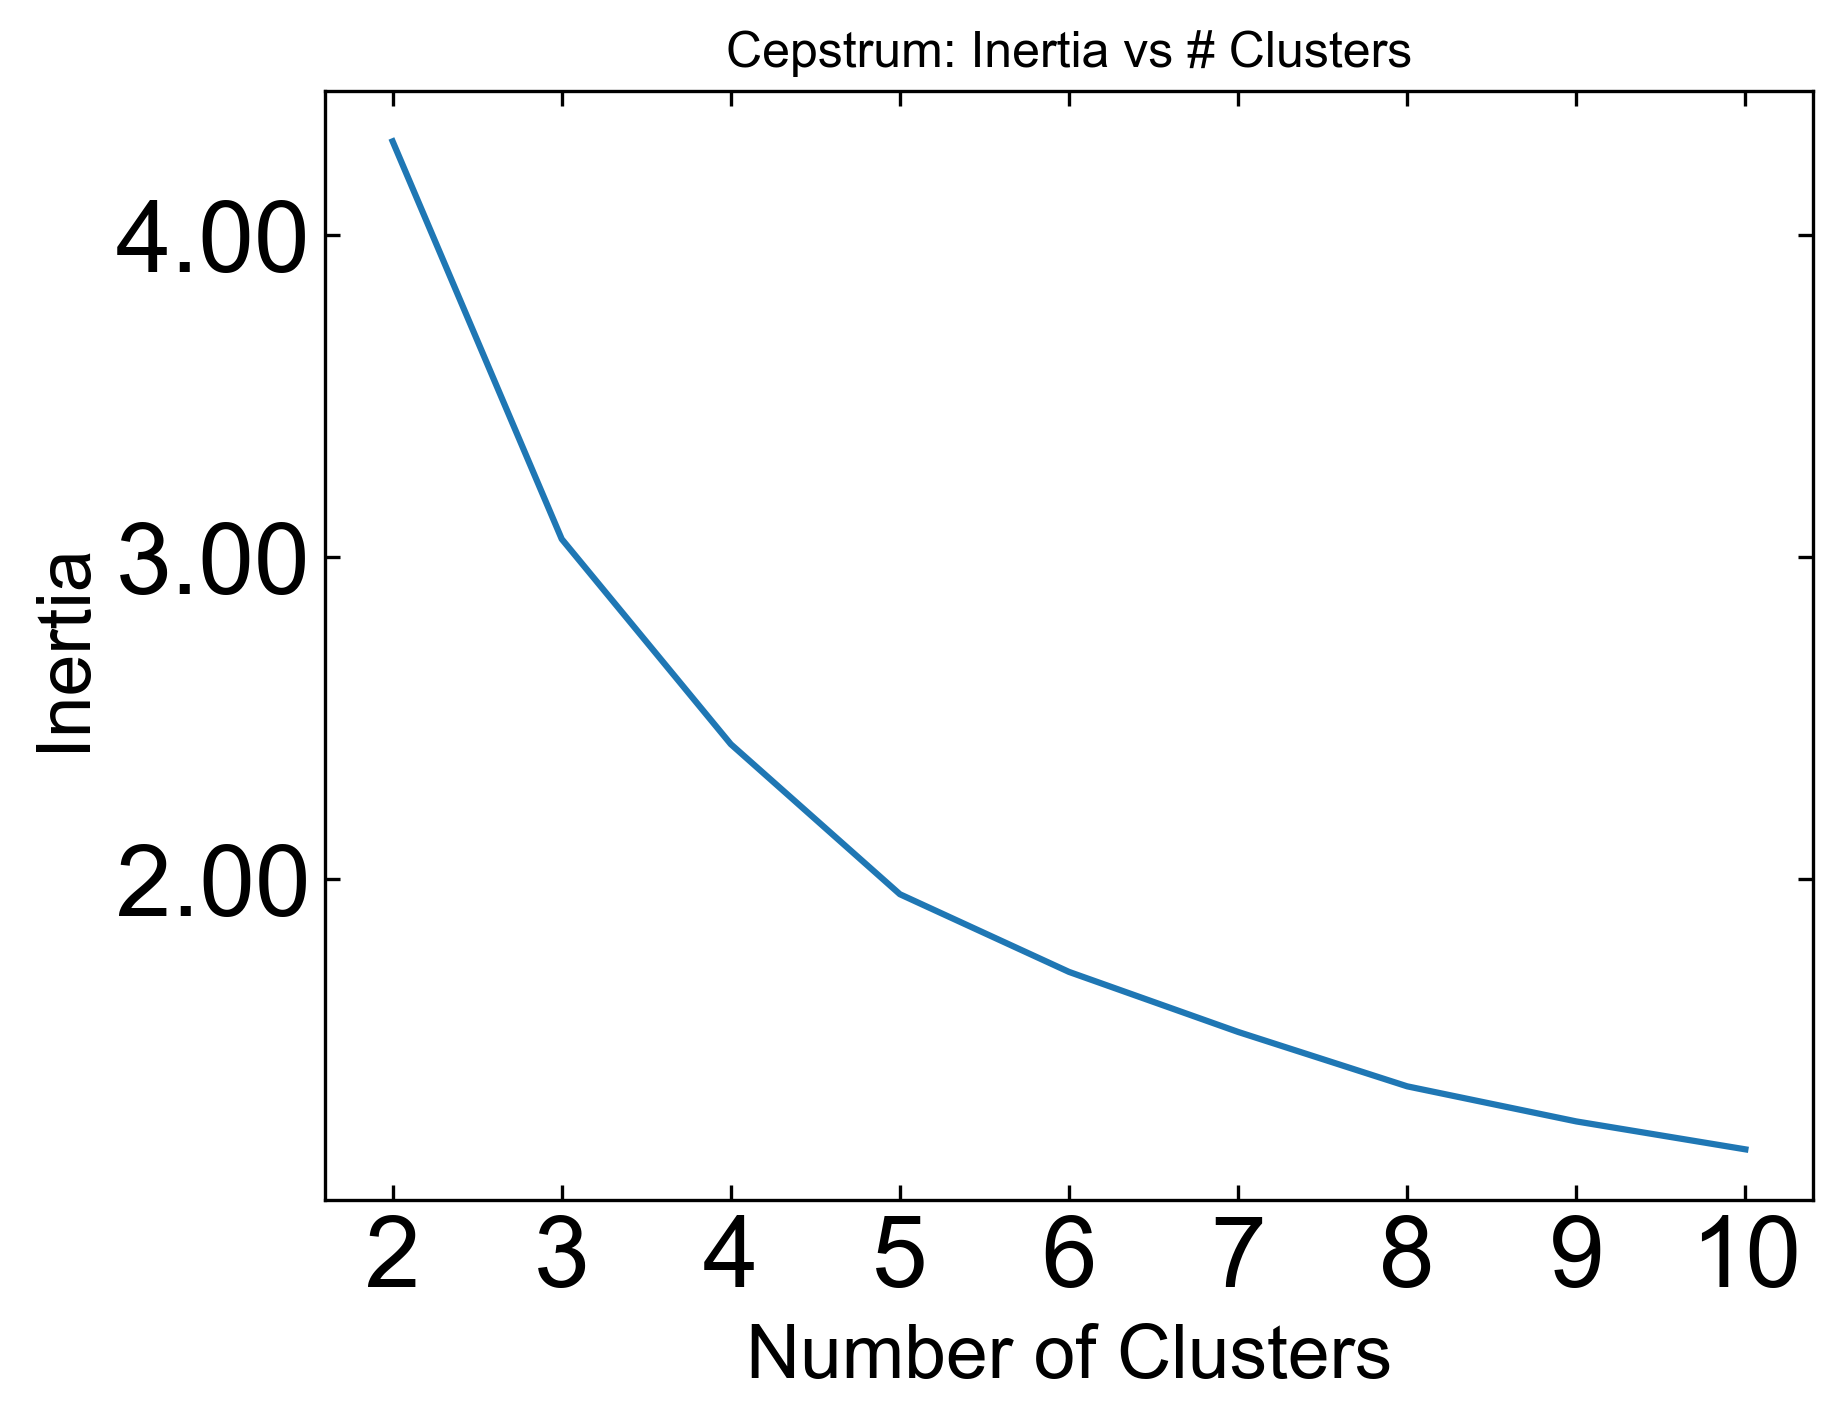

In [162]:
fig, ax = plt.subplots(dpi = 300)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,12,1)
ax.plot(n[0:9], kcn_inertia[0:9])
plt.title("Cepstrum: Inertia vs # Clusters")
plt.ylabel('Inertia', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 18)
plt.xticks(n[0:9],n[0:9])

### 5 clusters NBED

(-0.5, 127.5, 127.5, -0.5)

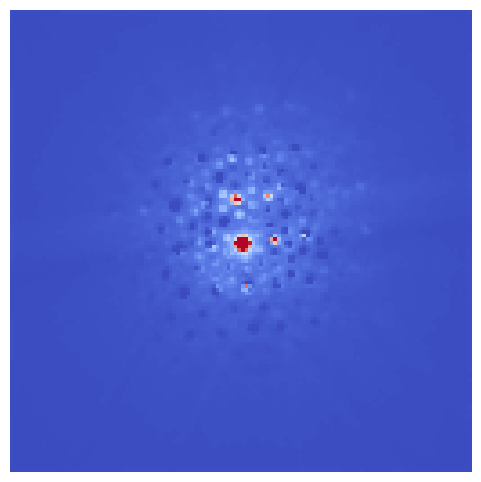

(-0.5, 127.5, 127.5, -0.5)

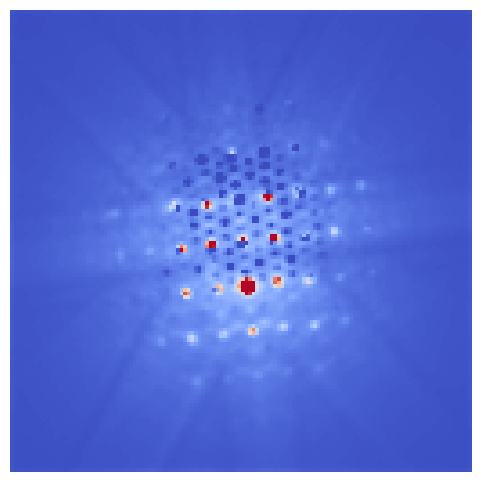

(-0.5, 127.5, 127.5, -0.5)

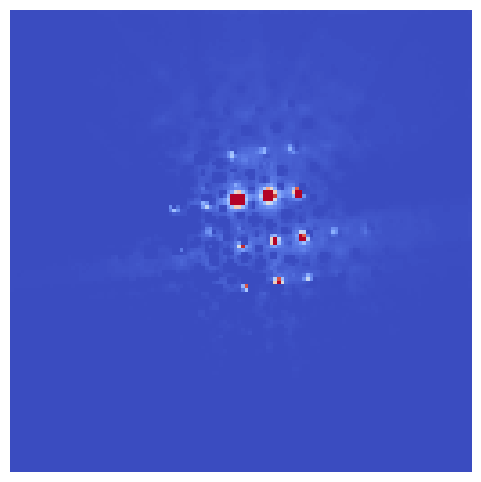

(-0.5, 127.5, 127.5, -0.5)

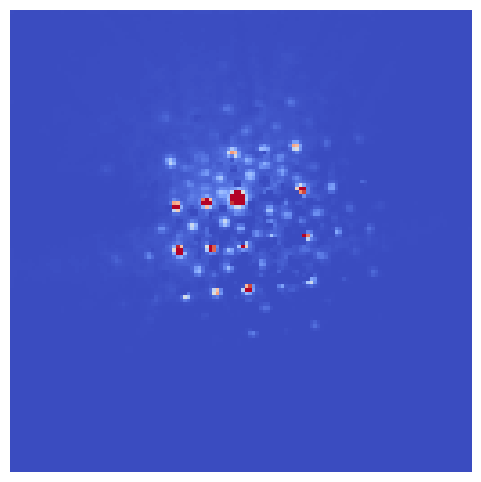

(-0.5, 127.5, 127.5, -0.5)

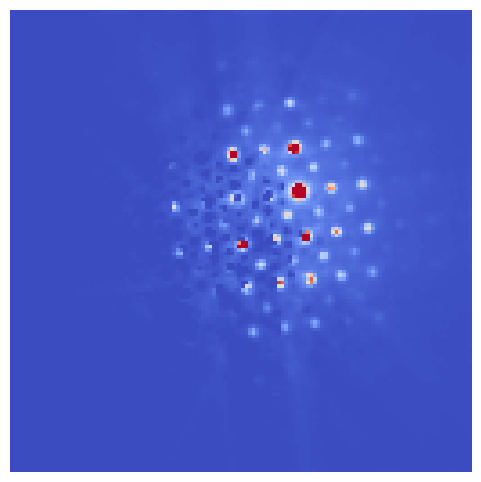

In [185]:
sma_nmf = np.load('smaGanmfWhole-160x410.npy')
H2 = nmf.components_
for i in range(5):
    fig, (ax1) = plt.subplots(1,1, figsize = (6,6))
    im1 = ax1.imshow(H2[i].reshape(IMG_SIZE, IMG_SIZE), cmap = 'coolwarm')
    ax1.axis('off')
    #ax1.set_title('nmf1 - 10 comp', fontsize = 26)
    im1.set_clim(0, 3*H2[i].std())


    plt.show()

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_23172\1355475508.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_nmf, cmap = cm.get_cmap('RdYlBu', nckn))


(-0.5, 159.5, 409.5, -0.5)

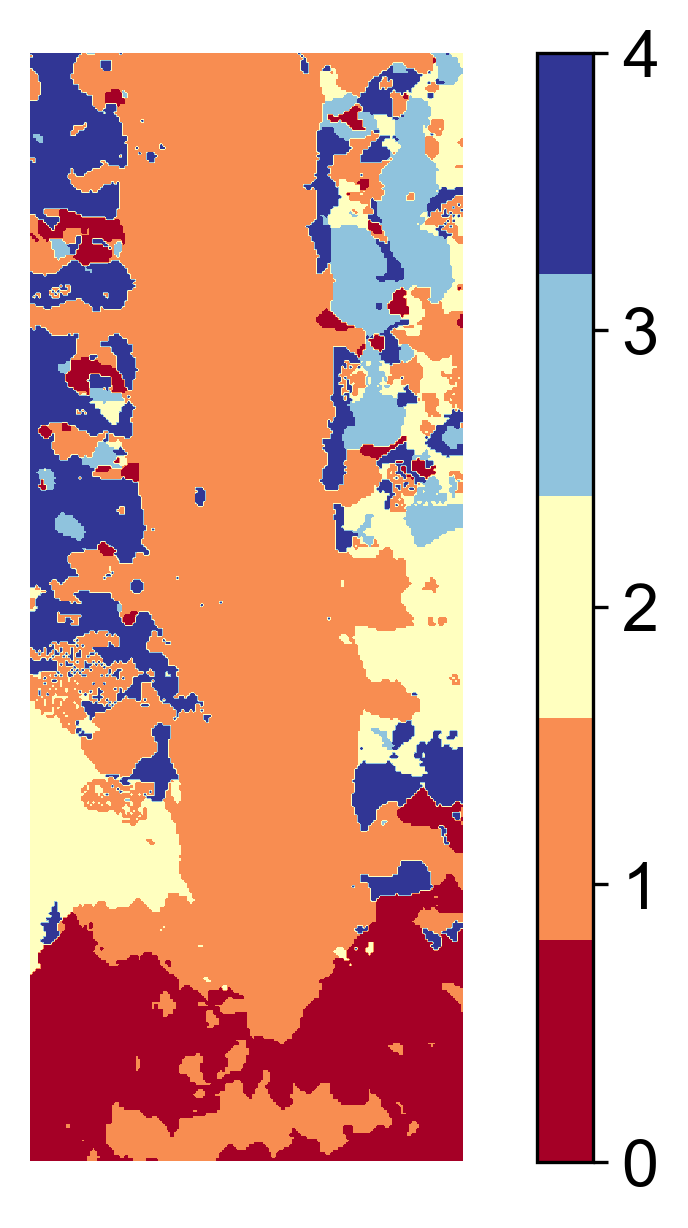

In [186]:
nckn = 5

for dataset_number in range(len(raw_list)):
    kmeans_nmf = KMeans(n_clusters = nckn, n_init = 10).fit(sma_nmf[dataset_number][:,:5]) # k = # of clusters

plt.figure(dpi = 300)
cluster_map_nmf = (np.reshape(kmeans_nmf.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_nmf, cmap = cm.get_cmap('RdYlBu', nckn))
plt.colorbar(ticks = np.arange(nckn)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [187]:
nmf_avg_dict = {}
for i in range(len(raw_list)):
    for x in range(nckn):
        nmf_avg_dict["nbed_{0}_avg_nmf".format(x)] = get_avg_dp(kmeans_nmf.labels_, x, nbeds[i].reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 3 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 4 NBED')

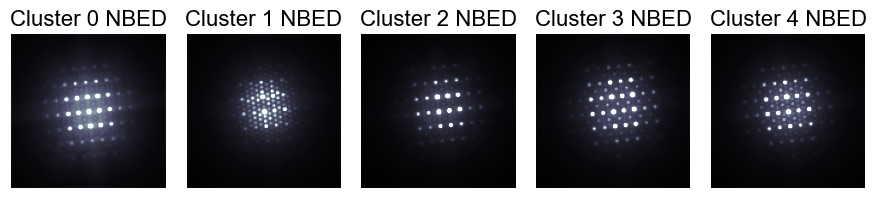

In [188]:
clim_ref = nmf_avg_dict["nbed_2_avg_nmf"]
n_max = clim_ref.mean() + 3*clim_ref.std()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (10, 2))
im1 = ax1.imshow(nmf_avg_dict["nbed_0_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 NBED', fontsize = 16)
im2 = ax2.imshow(nmf_avg_dict["nbed_1_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 NBED', fontsize = 16)
im3 = ax3.imshow(nmf_avg_dict["nbed_2_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 NBED', fontsize = 16)
im4 = ax4.imshow(nmf_avg_dict["nbed_3_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax4.axis('off')
ax4.set_title('Cluster 3 NBED', fontsize = 16)
im5 = ax5.imshow(nmf_avg_dict["nbed_4_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax5.axis('off')
ax5.set_title('Cluster 4 NBED', fontsize = 16)

fig.subplots_adjust(right=1)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

### 3 clusters Cepstral

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_23172\3607502803.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_cep_nmf, cmap = cm.get_cmap('RdYlBu',ncknc))


(-0.5, 159.5, 409.5, -0.5)

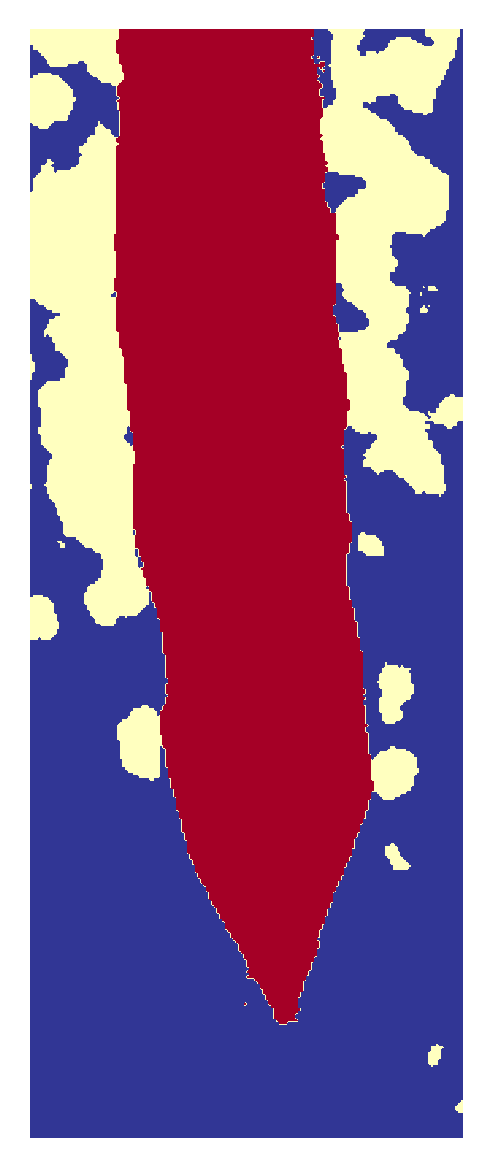

In [189]:
ncknc = 3

for dataset_number in range(len(raw_list)):
    kmeans_nmf = KMeans(n_clusters = nckn, n_init = 10).fit(sma_nmf_cep[dataset_number][:,:5]) # k = # of clusters

plt.figure(dpi = 300)
cluster_map_cep_nmf = (np.reshape(kmeans_cep_nmf.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_cep_nmf, cmap = cm.get_cmap('RdYlBu',ncknc))
#plt.colorbar(ticks = np.arange(ncknc)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [190]:
cep_nmf_avg_dict = {}
for i in range(len(raw_list)):
    for x in range(ncknc):
        cep_nmf_avg_dict["nbed_{0}_avg_cep_nmf".format(x)] = get_avg_dp(kmeans_cep_nmf.labels_, x, ceps[i].reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 Cepstrum')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 Cepstrum')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 Cepstrum')

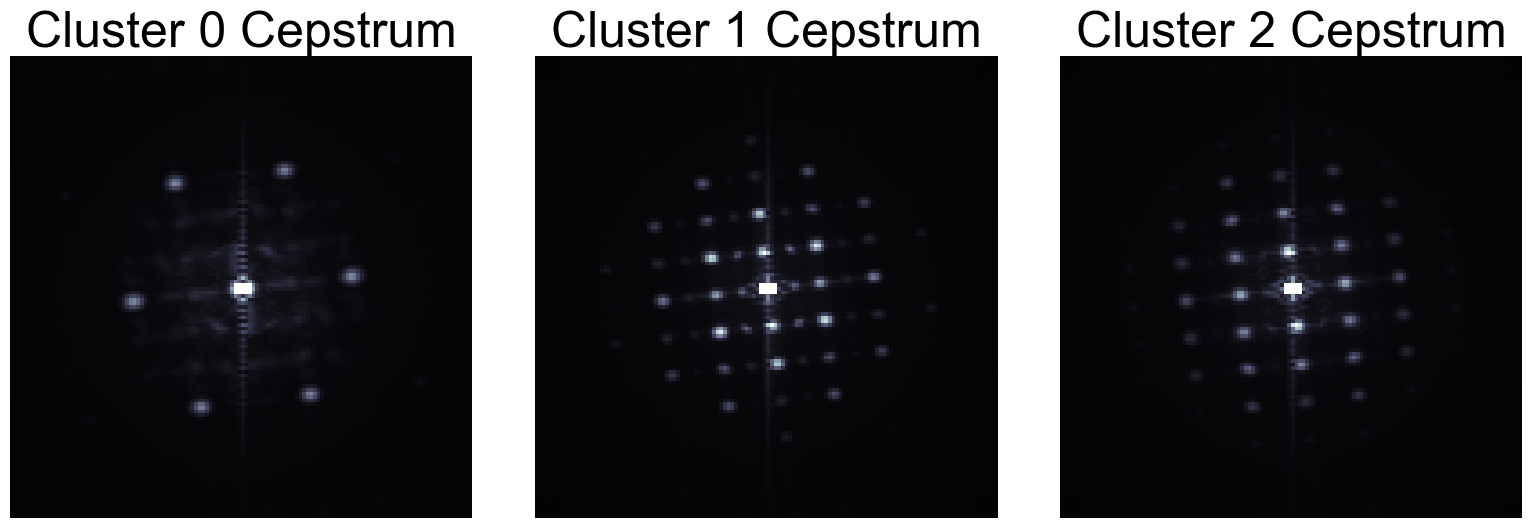

In [191]:
clim_ref = cep_nmf_avg_dict["nbed_2_avg_cep_nmf"]
c_max = clim_ref.mean() + 1*clim_ref.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 6))
im1 = ax1.imshow(cep_nmf_avg_dict["nbed_0_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax1.axis('off')
ax1.set_title('Cluster 0 Cepstrum', fontsize = 36)
im2 = ax2.imshow(cep_nmf_avg_dict["nbed_1_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax2.axis('off')
ax2.set_title('Cluster 1 Cepstrum', fontsize = 36)
im3 = ax3.imshow(cep_nmf_avg_dict["nbed_2_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax3.axis('off')
ax3.set_title('Cluster 2 Cepstrum', fontsize = 36)
# im4 = ax4.imshow(cep_nmf_avg_dict["nbed_3_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
# ax4.axis('off')
# ax4.set_title('Cluster 3 Cepstrum', fontsize = 36)
# im5 = ax5.imshow(cep_nmf_avg_dict["nbed_4_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax5.axis('off')
# ax5.set_title('Cluster 4 Cepstrum', fontsize = 36)
# im6 = ax6.imshow(cep_nmf_avg_dict["nbed_5_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax6.axis('off')
# ax6.set_title('Cluster 5 Cepstrum', fontsize = 36)

fig.subplots_adjust(right=1, wspace = None, hspace = None)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()